In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from tqdm import tqdm
from utils.model import *
from utils.data import select_cols
from utils.loss import *
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, randint, uniform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import IntegratedGradients
from joblib import dump, load

In [2]:
def predict_in_batches(model, dataset, batch_size=32):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(dataset), batch_size), desc="Predicting"):
            batch = dataset[i:i+batch_size]
            batch_predictions = model(batch)
            predictions.append(batch_predictions)
    return torch.cat(predictions, dim=0)

EXPLORATORY DATA ANALYSIS

In [3]:
train_file = pd.read_csv('./processed_data/train.csv').drop(['DeepSpCas9', 'Unnamed: 0'], axis=1)
valid_file = pd.read_csv('./processed_data/validate.csv').drop(['DeepSpCas9', 'Unnamed: 0'], axis=1)
test_file = pd.read_csv('./processed_data/test.csv').drop(['DeepSpCas9', 'Unnamed: 0'], axis=1)

In [4]:
train_file.columns

Index(['ED_pos', 'ED_len', 'type_sub', 'type_ins', 'type_del', 'PBS_len',
       'RTT_len', 'RHA_len', 'ext_len', 'WTS_GC', 'PBS_GC', 'RTT_GC', 'RHA_GC',
       'spacer_GC', 'ext_GC', 'WTS_Tm', 'PBS_Tm', 'RTT_Tm', 'RHA_Tm',
       'spacer_Tm', 'ext_Tm', 'PBS_MFE', 'RTT_MFE', 'spacer_MFE', 'ext_MFE',
       'ext_U', 'protoS_U', 'E'],
      dtype='object')

In [5]:
features_train, targets_train = select_cols(train_file)
features_valid, targets_valid = select_cols(valid_file)
features_test, targets_test = select_cols(test_file)

X_train = (features_train - features_train.mean()) / features_train.std()
X_valid = (features_valid - features_train.mean()) / features_train.std()
X_test = (features_test - features_train.mean()) / features_train.std()

X_train = X_train.values
t_train = targets_train.values

X_valid = X_valid.values
t_valid = targets_valid.values

X_test = X_test.values
t_test = targets_test.values

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
t_valid_tensor = torch.tensor(t_valid, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32)

In [ ]:
X_test.shape

MODEL TRAINING

In [ ]:
# Lasso

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100,
                                     random_state=42)
rf_regressor.fit(X_train, t_train)

In [ ]:
t_preds_valid = rf_regressor.predict(X_valid)
mse = mean_squared_error(t_valid, t_preds_valid)

t_preds_test = rf_regressor.predict(X_test)
s_rf, _ = spearmanr(t_preds_test, t_test)
p_rf, _ = pearsonr(t_preds_test, t_test)

print(f"Validation MSE: {mse}")
print(f"Test Spearman correlation coefficient: {s_rf}")
print(f"Test Pearson correlation coefficient: {p_rf}")

rf_regressor.feature_importances_

In [6]:
params = {"n_estimators": 100,
          "max_depth": 30,
          "min_samples_split": 100,
          "learning_rate": 0.01,
          "loss": "squared_error"}

gb_reg = GradientBoostingRegressor(**params)
gb_reg.fit(X_train, t_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=30,
                          min_samples_split=100)

In [8]:
t_preds_valid = gb_reg.predict(X_valid)
mse = mean_squared_error(t_valid, t_preds_valid)

t_preds_test = gb_reg.predict(X_test)
s_coef, _ = spearmanr(t_preds_test, t_test)
p_coef, _ = pearsonr(t_preds_test, t_test)

print(f"Validation MSE: {mse}")
print(f"Test Spearman correlation coefficient: {s_coef}")
print(f"Test Pearson correlation coefficient: {p_coef}")

Validation MSE: 151.80277645477662
Test Spearman correlation coefficient: 0.8505313221589043
Test Pearson correlation coefficient: 0.8935241462914176


In [9]:
dump(gb_reg, './models/GBmodel.joblib')

['./models/GBmodel.joblib']

In [ ]:
# param_dist = {
#     'colsample_bytree': uniform(0.5, 0.5),  # Uniform distribution in [0.5, 1.0]
#     'learning_rate': uniform(0.01, 0.29),  # Uniform distribution in [0.01, 0.3]
#     'max_depth': randint(3, 10),  # Uniformly distributed integer in [3, 10]
#     'alpha': randint(0, 10),  # Uniformly distributed integer in [0, 10]
#     'n_estimators': randint(50, 150)  # Uniformly distributed integer in [50, 150]
# }
# 
# xgb_reg = XGBRegressor(objective='reg:squarederror')
# 
# random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist,
#                                    n_iter=100, scoring='neg_mean_squared_error',
#                                    cv=5, verbose=1, random_state=42, n_jobs=-1)
# 
# random_search.fit(X_train, t_train)
# 
# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)

In [6]:
params = {'alpha': 2, 'colsample_bytree': 0.7063088384557132, 'learning_rate': 0.1178852448799071, 'max_depth': 9, 'n_estimators': 145}

xgb_reg = XGBRegressor(**params)

xgb_reg.fit(X_train, t_train)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7063088384557132, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1178852448799071, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=145, n_jobs=None,
             num_parallel_tree=None, ...)

In [7]:
t_preds_valid = xgb_reg.predict(X_valid)
mse = mean_squared_error(t_valid, t_preds_valid)

t_preds_test = xgb_reg.predict(X_valid)
s_coef, _ = spearmanr(t_preds_valid, t_valid)

print(f"Validation MSE: {mse}")
print(f"Test Spearman correlation coefficient: {s_coef}")

Validation MSE: 96.86523149116984
Test Spearman correlation coefficient: 0.8378961113784008


In [8]:
dump(xgb_reg, './models/XGB.joblib')

['XGB.joblib']

NEURAL NETS 

In [7]:
dataset = TensorDataset(X_train_tensor, t_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [8]:
model = FFNN()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [9]:
num_epochs = 10

progress_bar = tqdm(total=num_epochs, desc='Training Progress')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))

        # Backpropogation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_mse = running_loss / len(dataloader) 

    progress_bar.set_postfix(epoch=epoch+1, MSE=epoch_mse, refresh=True)
    progress_bar.update(1)

progress_bar.close()
print('Training completed')

Training Progress: 100%|██████████| 10/10 [01:38<00:00,  9.82s/it, MSE=102, epoch=10]

Training completed


In [10]:
torch.save(model, './models/ffnn.pth') 
torch.save(model.state_dict(), './models/ffnn_state_dict.pth')

In [18]:
model = torch.load('./models/cnn.pth')

In [12]:
t_preds_valid = predict_in_batches(model, X_valid_tensor).numpy().flatten()
t_preds_test = predict_in_batches(model, X_test_tensor).numpy().flatten()

mse = mean_squared_error(t_valid, t_preds_valid)

s_coef, _ = spearmanr(t_preds_test, t_test)
p_coef, _ = pearsonr(t_preds_test, t_test)

print(f"Validation MSE: {mse}")
print(f"Test Spearman correlation coefficient: {s_coef}")
print(f"Test Pearson correlation coefficient: {p_coef}")

Predicting: 100%|██████████| 2092/2092 [00:00<00:00, 12588.62it/s]

Validation MSE: 105.24554314847724
Test Spearman correlation coefficient: 0.8367057101579888
Test Pearson correlation coefficient: 0.8862526673916842


In [20]:
X_df = pd.read_csv('X_df.csv')
library = pd.read_csv('./saturation/library.csv')
input = X_df[['ED_pos', 'ED_len', 'type_sub', 'type_ins', 'type_del', 'PBS_len',
            'RTT_len', 'RHA_len', 'ext_len', 'WTS_GC', 'PBS_GC', 'RTT_GC', 'RHA_GC',
            'spacer_GC', 'ext_GC', 'WTS_Tm', 'PBS_Tm', 'RTT_Tm', 'RHA_Tm',
            'spacer_Tm', 'ext_Tm', 'PBS_MFE', 'RTT_MFE', 'spacer_MFE', 'ext_MFE',
            'ext_U', 'protoS_U']]

input_tensor = torch.tensor(input.values, dtype=torch.float32)

predictions = model(input_tensor)

library['Efficiency Prediction'] = np.maximum(predictions.detach().numpy(), 0)

library.to_csv('./saturation/saturation_preds.csv')

MODEL EVAL

In [ ]:
# Compare to others in lit and made (neural nets, classical)
# Generate figures.

In [13]:
t_test_np = t_test.flatten()
t_valid_np = t_valid.flatten()

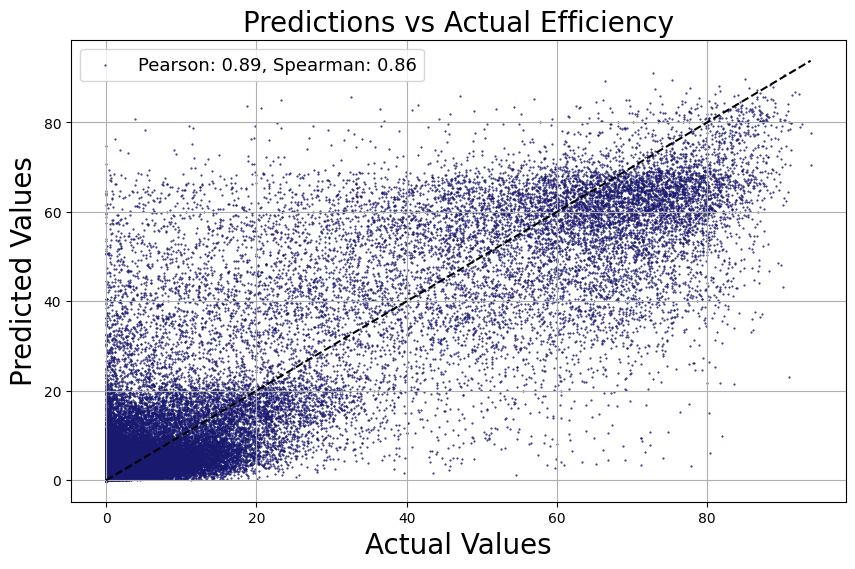

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(t_test_np, t_preds_test, s=1, marker=".",  c='midnightblue')
plt.title('Predictions vs Actual Efficiency', fontsize=20)
plt.xlabel('Actual Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.grid(True)

legend_label = f'Pearson: 0.89, Spearman: 0.86'
plt.legend([legend_label], loc='upper left', fontsize=13)

max_val = max(max(t_test_np), max(t_preds_test))
plt.plot([0, max_val], [0, max_val], 'k--')

plt.show()

In [ ]:
models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Feed-Forward \n Neural Network', 'Convolutional \n Neural Network']
scores = [
    [0.8207, 0.819, 0.818],
    [0.8413, 0.842, 0.838],
    [0.8463, 0.847, 0.846],
    [0.852, 0.851, 0.853],
    [0.859, 0.853, 0.858]
]

# Calculate means and standard deviations
means = [np.mean(score) for score in scores]
std_devs = [np.std(score) for score in scores]

# Plotting
x_pos = np.arange(len(models))

fig, ax = plt.subplots()
bars = ax.bar(x_pos, means, yerr=std_devs, capsize=10, alpha=1, color='midnightblue')

# Spreading out individual points for each bar
for i, score in enumerate(scores):
    spread = np.linspace(-0.1, 0.1, len(score))
    ax.scatter([i + s for s in spread], score, s=2, color='red')

ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("Pearson's r")
ax.set_title('Model Performance Comparison')
ax.set_ylim([0.7, None])  # Setting the y-axis minimum to 0.6

plt.tight_layout()
plt.show()


In [13]:
model.eval()

CNN(
  (conv1): Conv1d(28, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
integrated_gradients = IntegratedGradients(model)

# Define a function to process data in batches
def compute_ig_in_batches(data_tensor, batch_size=50):
    n_samples = data_tensor.shape[0]
    all_attributions = []

    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_data = data_tensor[start_idx:end_idx]
        attributions = integrated_gradients.attribute(batch_data)
        all_attributions.append(attributions.cpu().detach().numpy())

    all_attributions = np.concatenate(all_attributions, axis=0)
    return all_attributions

attributions_batched = compute_ig_in_batches(X_train_tensor, batch_size=50)

In [15]:
attributions_batched

array([[ -0.16619392, -17.8933871 ,  -4.79852528, ...,  -7.34209118,
         -2.19647683,  -0.21980705],
       [ -3.96255306,  -0.17506367,  -1.36943884, ...,  -0.43018823,
         -4.67035148,  -0.6199029 ],
       [  0.46920133,  25.26788209,  -3.91582228, ...,  -2.43648876,
         -5.30897554,   0.20450999],
       ...,
       [  0.26764431,  52.20977065,   1.85000721, ...,  -4.86361058,
          0.80241165,   0.24724764],
       [ -0.82302568, -17.60019317,  -0.17736669, ...,  -0.51668858,
         -0.29218681,   0.25694207],
       [ -1.49210727, -15.56863774,  -0.1668342 , ...,  -1.60190194,
          0.11618798,   0.10349207]])

In [26]:
mean_abs_attributions = np.mean(np.abs(attributions_batched), axis=0)

sorted_indices = np.argsort(mean_abs_attributions)[-10:]
top_mean_abs_attributions = mean_abs_attributions[sorted_indices]
top_feature_labels = train_file.columns[:-1][sorted_indices]

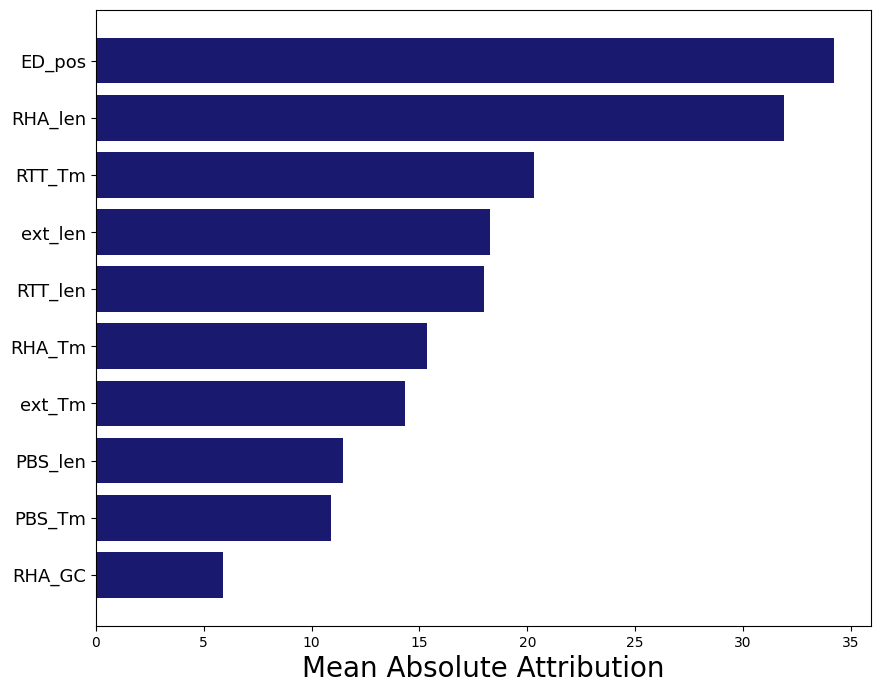

In [27]:
plt.figure(figsize=(10, 8)) 
plt.barh(range(len(top_mean_abs_attributions)), top_mean_abs_attributions, color='midnightblue')
plt.yticks(ticks=range(len(top_mean_abs_attributions)), labels=top_feature_labels, fontsize=13)
plt.xlabel('Mean Absolute Attribution', fontsize=20)
# plt.title('pegRNA Feature Importance in Predicting Editing Efficiency', fontsize=20)
plt.show()

In [ ]:
model

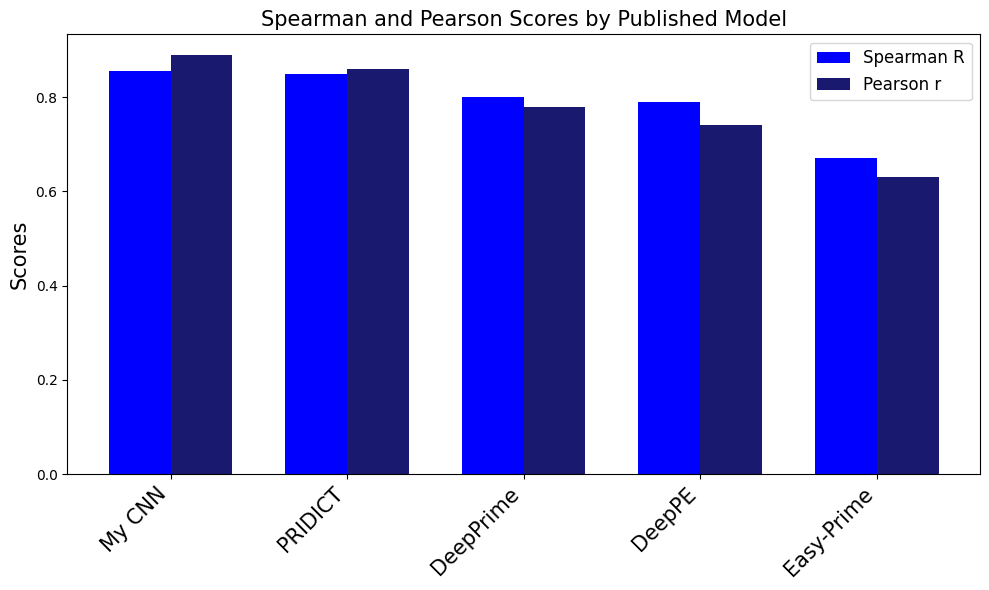

In [2]:
methods = ['My CNN', 'PRIDICT', 'DeepPrime', 'DeepPE', 'Easy-Prime']
spearman_scores = [0.856, 0.85, 0.8, 0.79, 0.67]
pearson_scores = [0.889, 0.86, 0.78, 0.74, 0.63]
bar_width = 0.35

index = range(len(methods))

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, spearman_scores, bar_width, label='Spearman R', color='blue')
bars2 = ax.bar([p + bar_width for p in index], pearson_scores, bar_width, label='Pearson r', color='midnightblue')

ax.set_ylabel('Scores', fontsize=15)
ax.set_title('Spearman and Pearson Scores by Published Model', fontsize=15)
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(methods)
ax.legend(fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=15)

plt.tight_layout()
plt.show()